In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from xgboost import plot_tree
from sklearn.model_selection import train_test_split


In [112]:
def create_features(df):
    df = df.copy()
    df['minute'] =df.index.minute
    df['hour'] = df.index.hour
    df['dayofweek']=df.index.dayofweek
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    return df

In [113]:
def add_lags(df):
    target_map = df['oxygenValue'].to_dict()
    df['lag_1']=(df.index - pd.Timedelta('1 day')).map(target_map)
    df['lag_2']=(df.index - pd.Timedelta('2 day')).map(target_map)
    df['lag_3']=(df.index - pd.Timedelta('3 day')).map(target_map)
    return df

In [114]:
paramsRF = {
  "colsample_bynode": 0.9,
  "learning_rate":0.8,
  "max_depth": 9,
  "num_parallel_tree": 150,
  "objective": "reg:squarederror",
  "subsample": 0.9,
  "tree_method": "hist",
  "device": "cuda"
}

# Future prediction

In [115]:
df = pd.read_parquet('../data/cleanedData/allData.parquet')
df.set_index('measurementDate', inplace=True)

In [116]:
tss = TimeSeriesSplit(n_splits=5, test_size=60*24*30, gap=60*24)
df = df.sort_index()

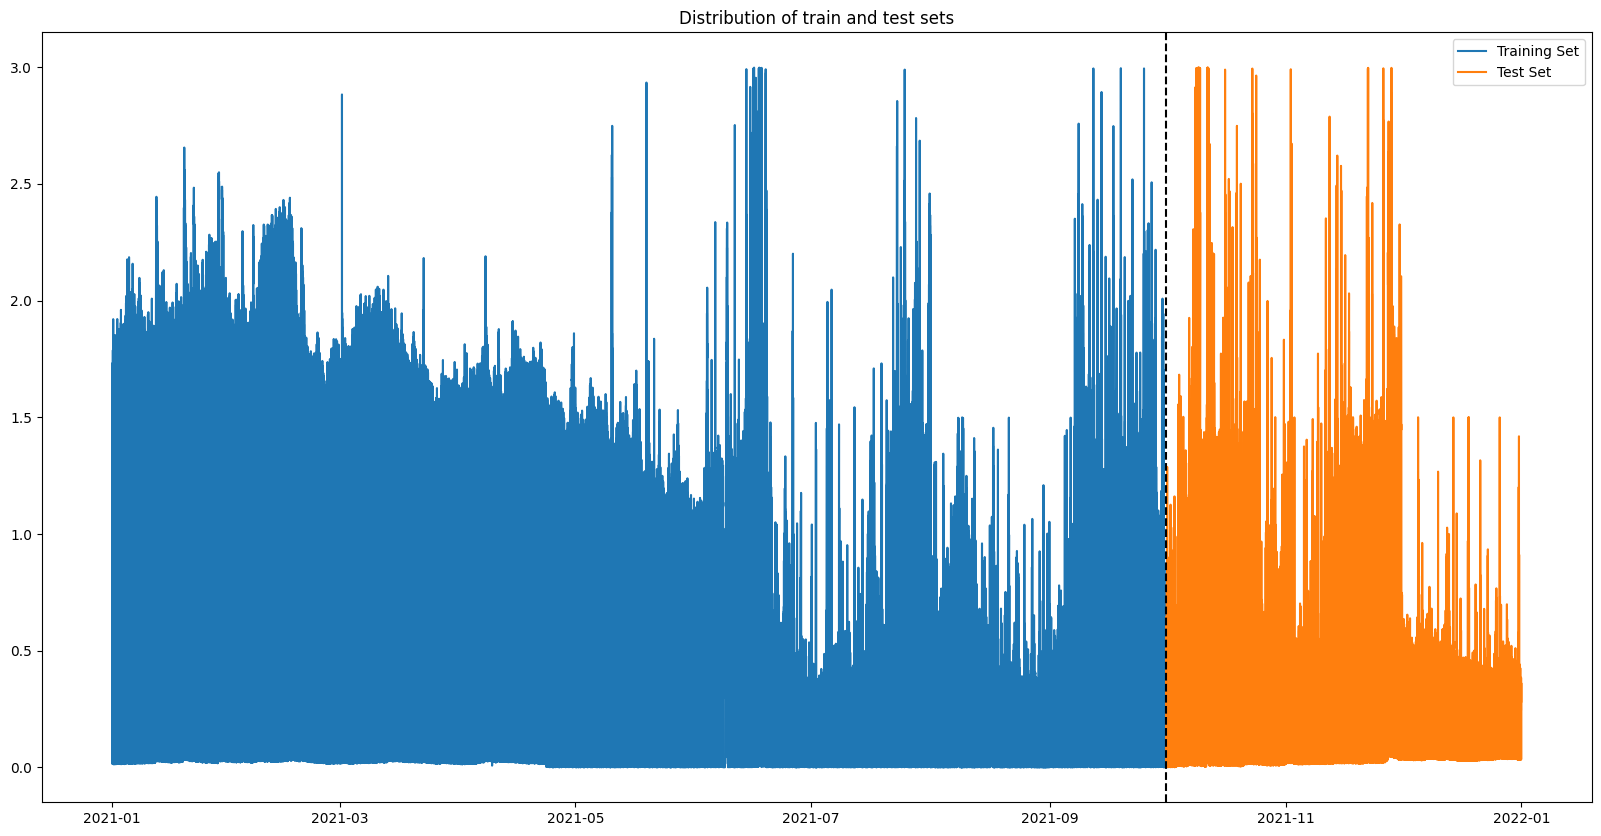

In [117]:
train = df.loc[df.index<'2021-10-01']
test = df.loc[df.index>='2021-10-01']

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train.index,train['oxygenValue'])
plt.plot(test.index,test['oxygenValue'])
ax.axvline(pd.to_datetime('2021-10-01'),color='black', ls='--')
plt.title("Distribution of train and test sets")
plt.legend(['Training Set','Test Set'])
plt.show()

# Forecasting Horizon:
The forcasting horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long term horizons (more than two years).

For our project we chose the short term prediction of one month

# Future prediction

In [118]:

#for feature in ['nitrateValue', 'phosphateValue', 'ammoniumValue',]:
    #df[feature] = np.log1p(df[feature])

FEATURES= ['nitrateValue', 'phosphateValue', 'ammoniumValue',
       'waterFlowPerMinute', 'precipitation', 'minute', 'hour', 'dayofweek',
       'quarter', 'month', 'lag_1', 'lag_2', 'lag_3']
TARGET = 'oxygenValue'

df = create_features(df)
df= add_lags(df)
df.dropna(inplace=True)
X = df[FEATURES]
y = df[TARGET]

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [120]:
fold = 0
preds =[]
scores =[]
r2_scores = []
mae_scores = []



for train_idx, val_idx in tss.split(X_train):
    train= df.iloc[train_idx]
    test = df.iloc[val_idx]

    train= create_features(train)
    test = create_features(test)
    
    X_train, y_train = train[FEATURES], train[TARGET]
    X_test, y_test = test[FEATURES], test[TARGET]

    reg = xgb.XGBRFRegressor(**paramsRF)
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=1)
    fold+=1

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = root_mean_squared_error(y_test,y_pred)
    scores.append(score)
    r2= r2_score(y_test,y_pred)
    r2_scores.append(r2)
    mae = mean_absolute_error(y_test,y_pred)
    mae_scores.append(mae)


[0]	validation_0-rmse:0.60890	validation_1-rmse:0.60875
[0]	validation_0-rmse:0.59409	validation_1-rmse:0.50060
[0]	validation_0-rmse:0.55347	validation_1-rmse:0.48586
[0]	validation_0-rmse:0.53943	validation_1-rmse:0.41434
[0]	validation_0-rmse:0.52382	validation_1-rmse:0.62191


In [121]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

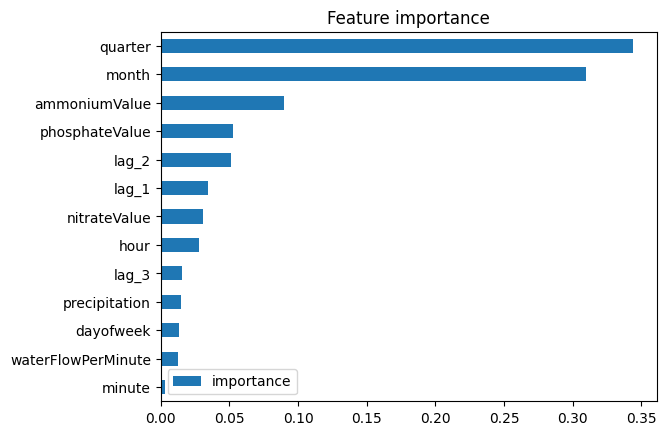

In [122]:
fi.sort_values('importance').plot(kind='barh', title="Feature importance")
plt.show()

In [123]:
# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_test shape:", y_test.shape)

# print("Null values in X_train:", X_train.isnull().sum())
# print("Null values in X_test:", X_test.isnull().sum())



In [124]:
print(f'Score across folds: {np.mean(scores):0.4f}')
print(f'Fold scores: {scores}')
print(f'R2 score across the folds:  {np.mean(r2_scores):0.4f}')
#print(f'Fold R2 scores: {r2_scores}')
print(f'Mean Absolute Error: {np.mean(mae_scores):0.4f}')
print(f'Mean Absolute Errors per fold: {mae_scores}')

Score across folds: 0.5263
Fold scores: [0.6087468381663764, 0.5005968761207275, 0.4858645898889279, 0.41434039879733614, 0.621909591528034]
R2 score across the folds:  -0.4862
Mean Absolute Error: 0.4244
Mean Absolute Errors per fold: [0.49409470101919983, 0.453513638648882, 0.35399694090275297, 0.33252795829932996, 0.48777684465098714]


In [125]:
HYPER_PARAMETERS_DF: pd.DataFrame

try:
   HYPER_PARAMETERS_DF =  pd.read_csv('hyperParameters.csv')
except:
	HYPER_PARAMETERS_DF = pd.DataFrame(columns=["colsample_bynode", "learning_rate", "max_depth", 
                                    "num_parallel_tree", "objective", "subsample", 
                                    "tree_method", "device", "MAE", "RMSE"])

new_row = pd.DataFrame([paramsRF])
HYPER_PARAMETERS_DF = pd.concat([HYPER_PARAMETERS_DF, new_row], ignore_index=True)
HYPER_PARAMETERS_DF['MAE'] = np.mean(mae_scores)
HYPER_PARAMETERS_DF['RMSE'] = np.mean(scores)

HYPER_PARAMETERS_DF.to_csv('hyperParameters.csv', index=False)

In [126]:

test['prediction']=reg.predict(X_test)
df= df.merge(test[['prediction']],how='left',left_index=True,right_index=True)

ValueError: Length of values (104091) does not match length of index (43200)

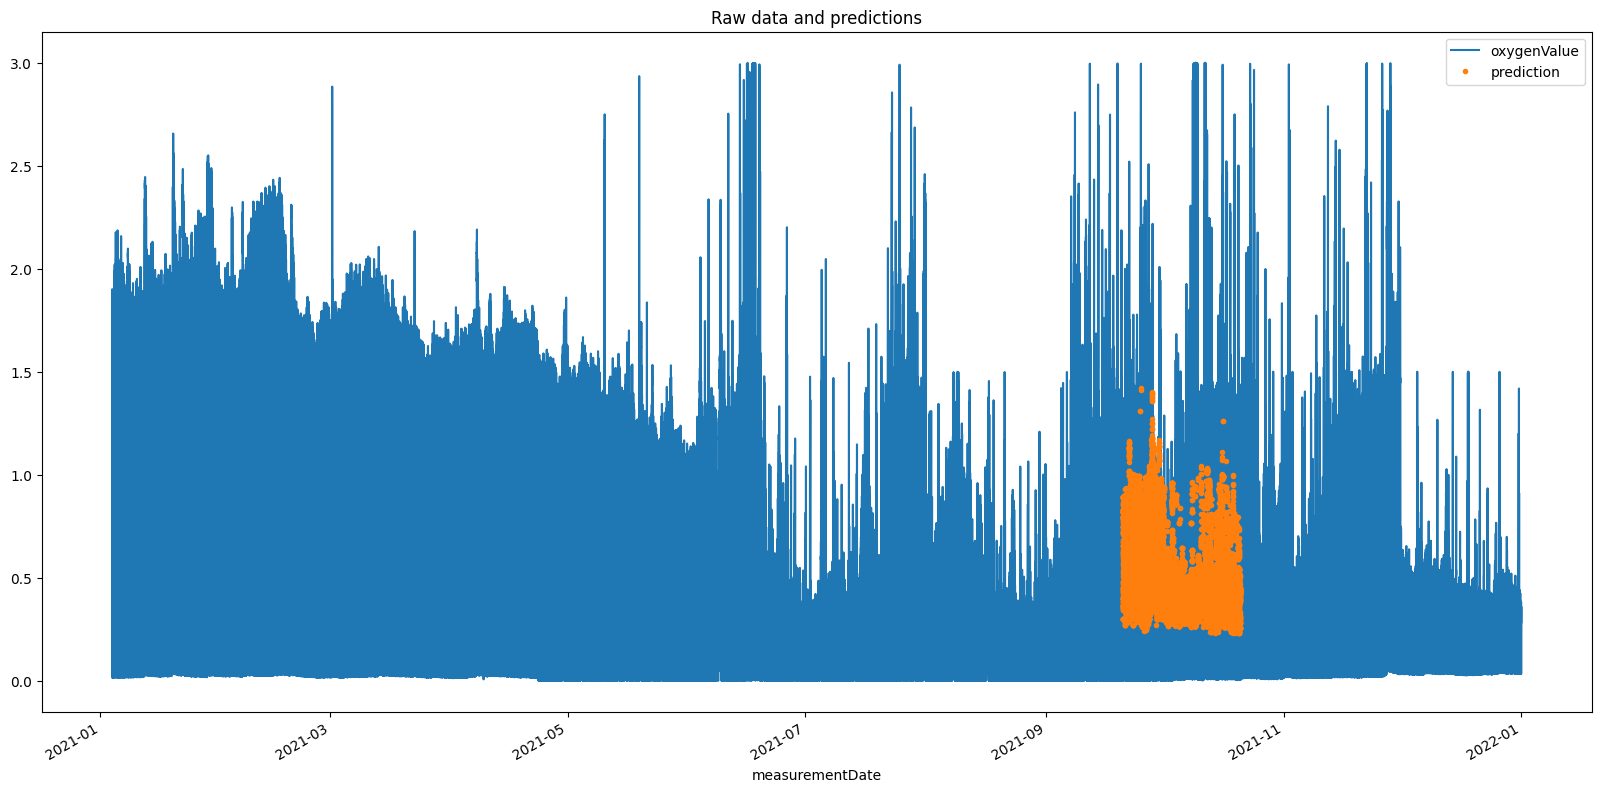

In [ ]:
ax = df[['oxygenValue']].plot(figsize=(20,10))
df['prediction'].plot(ax=ax,style='.')
plt.legend()
ax.set_title('Raw data and predictions')
plt.show()